In [2]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import sklearn
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

# Article data

Article: https://www.frontiersin.org/articles/10.3389/fpubh.2020.00357/full

In [4]:
data_dir = os.path.join('datasets', 'covid', 'cvd')
train_data_csv = os.path.join(data_dir, 'train.csv')
X_df = pd.read_csv(train_data_csv)

In [5]:
X_df

,id,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6
0,49,"Wuhan, Hubei",China,male,61.0,12/20/2019,12/27/2019,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,50,"Wuhan, Hubei",China,male,69.0,12/30/2019,1/3/2020,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,51,"Wuhan, Hubei",China,male,89.0,NaN,NaN,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
3,52,"Wuhan, Hubei",China,male,89.0,1/13/2020,1/13/2020,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
4,53,"Wuhan, Hubei",China,male,66.0,1/10/2020,1/16/2020,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,1033,Egypt,Egypt,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
218,1034,Qom,Iran,NaN,NaN,NaN,NaN,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
219,1035,Qom,Iran,NaN,NaN,NaN,NaN,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
220,1036,Qom,Iran,NaN,NaN,NaN,NaN,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN


## Pitfall 1 : not looking at your data

In [5]:
X_df.isna().sum()

id              0
location        0
country         0
gender         11
age            19
sym_on        103
hosp_vis      103
vis_wuhan       0
from_wuhan      0
death           0
symptom1      171
symptom2      200
symptom3      209
symptom4      222
symptom5      222
symptom6      222
dtype: int64

In [6]:
X_df['symptom2'].value_counts()

 cough                  12
 fever                   2
 sore throat             2
 chills                  1
 shortness of breath     1
 headache                1
 runny nose              1
 pneumonia               1
 loss of appetite        1
Name: symptom2, dtype: int64

In [7]:
X_df['from_wuhan'].value_counts()

0    159
1     63
Name: from_wuhan, dtype: int64

In [8]:
X_df.groupby('from_wuhan')['vis_wuhan'].value_counts()

from_wuhan  vis_wuhan
0           0            124
            1             35
1           0             63
Name: vis_wuhan, dtype: int64

In [9]:
X_df['country'].value_counts()

Singapore      62
China          42
South Korea    28
Malaysia       19
Japan          18
Vietnam         8
UK              6
Iran            4
France          4
UAE             4
Hong Kong       4
Australia       4
Thailand        4
USA             3
Phillipines     2
Canada          2
Russia          2
Spain           2
Sri Lanka       1
Nepal           1
Egypt           1
Taiwan          1
Name: country, dtype: int64

In [10]:
X_df['location'].value_counts()

Singapore             62
Wuhan, Hubei          32
South Korea           27
Malaysia              10
Hubei                  9
Johor                  8
London                 6
Vinh Phuc              6
Hokkaido               5
NSW                    4
UAE                    4
Paris                  4
Tokyo                  4
Thailand               4
Qom                    4
Toronto                2
Manila                 2
Hong Kong              2
Kowloon                2
Illinois               2
Ho Chi Minh City       2
Nagoya City            2
Kanagawa               2
Mallorca               1
Japan                  1
Canary Islands         1
Zabaikalsky            1
Sri Lanka              1
Taiwan                 1
Tyumen                 1
Ishikawa               1
Egypt                  1
Sagamihara             1
Washington             1
Chiba Prefecture       1
Shandong               1
Kathmandu              1
Saitama Prefecture     1
Seoul                  1
Langkawi               1


In [11]:
X_df.groupby('country')['death'].value_counts()

country      death
Australia    0         4
Canada       0         2
China        1        39
             0         3
Egypt        0         1
France       0         2
             1         2
Hong Kong    0         2
             1         2
Iran         1         4
Japan        0        13
             1         5
Malaysia     0        19
Nepal        0         1
Phillipines  0         1
             1         1
Russia       0         2
Singapore    0        62
South Korea  0        19
             1         9
Spain        0         2
Sri Lanka    0         1
Taiwan       1         1
Thailand     0         4
UAE          0         4
UK           0         6
USA          0         3
Vietnam      0         8
Name: death, dtype: int64

## Pitfall 2 : not addressing your missing variables properly

In [12]:
X_df['diff_sym_hos'] = pd.to_datetime(X_df['hosp_vis']) - pd.to_datetime(X_df['sym_on'])
X_df['diff_sym_hos']

0     7 days
1     4 days
2        NaT
3     0 days
4     6 days
       ...  
217      NaT
218      NaT
219      NaT
220      NaT
221      NaT
Name: diff_sym_hos, Length: 222, dtype: timedelta64[ns]

In [13]:
# Fill NA with median
symptoms_to_visit_median = X_df['diff_sym_hos'].median()
X_df['diff_sym_hos'] = X_df['diff_sym_hos'].fillna(symptoms_to_visit_median)
# Convert time period into number of days (integer)
X_df['diff_sym_hos'] = X_df['diff_sym_hos'].dt.days
# Show result
X_df['diff_sym_hos']

0      7
1      4
2      2
3      0
4      6
      ..
217    2
218    2
219    2
220    2
221    2
Name: diff_sym_hos, Length: 222, dtype: int64

In [14]:
most_frequent_gender = X_df['gender'].value_counts().index[0]
X_df['gender'] = X_df['gender'].fillna(most_frequent_gender)

In [15]:
X_df['age'] = X_df['age'].fillna(X_df['age'].median())

## Pitfall 3 : not transforming your variables properly

In [16]:
X_df.columns

Index(['id', 'location', 'country', 'gender', 'age', 'sym_on', 'hosp_vis',
       'vis_wuhan', 'from_wuhan', 'death', 'symptom1', 'symptom2', 'symptom3',
       'symptom4', 'symptom5', 'symptom6', 'diff_sym_hos'],
      dtype='object')

In [17]:
y = X_df['death']

In [18]:
X_selec_df = X_df.drop(['id', 'location', 'sym_on', 'hosp_vis', 'death', 'symptom1', 'symptom2', 
                        'symptom3', 'symptom4', 'symptom5', 'symptom6'], axis=1)

In [19]:
X_selec_df.columns

Index(['country', 'gender', 'age', 'vis_wuhan', 'from_wuhan', 'diff_sym_hos'], dtype='object')

In [20]:
X = pd.get_dummies(X_selec_df, drop_first=True)
X

,age,vis_wuhan,from_wuhan,diff_sym_hos,country_Canada,country_China,country_Egypt,country_France,country_Hong Kong,country_Iran,...,country_South Korea,country_Spain,country_Sri Lanka,country_Taiwan,country_Thailand,country_UAE,country_UK,country_USA,country_Vietnam,gender_male
0,61.0,0,1,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,69.0,0,1,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,89.0,0,1,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,89.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,66.0,0,1,6,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,51.0,0,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
218,51.0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
219,51.0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
220,51.0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [21]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [22]:
from sklearn.pipeline import make_pipeline

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
#cat_cols_to_encode = ['country', 'gender']
num_cols_to_scale = ['age', 'diff_sym_hos']
preprocessor = make_column_transformer(
 #   (OneHotEncoder(drop='if_binary'), cat_cols_to_encode),
    (StandardScaler(), num_cols_to_scale),
    remainder='passthrough'
)

In [25]:
lm_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression()
)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
from sklearn.metrics import f1_score as fs
from sklearn.metrics import log_loss

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [28]:
X_train

,age,vis_wuhan,from_wuhan,diff_sym_hos,country_Canada,country_China,country_Egypt,country_France,country_Hong Kong,country_Iran,...,country_South Korea,country_Spain,country_Sri Lanka,country_Taiwan,country_Thailand,country_UAE,country_UK,country_USA,country_Vietnam,gender_male
1,69.0,0,1,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,89.0,0,1,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
56,75.0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,55.0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,82.0,0,1,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,42.0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,40.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15,70.0,0,1,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125,62.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
lm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'diff_sym_hos'])])),
                ('logisticregression', LogisticRegression())])

### Pitfall 4 : not looking at performance properly

In [31]:
y_pred = np.array(lm_pipeline.predict(X_test))
# Scores
recall_lr = rs(y_test, y_pred)
precision_lr = ps(y_test, y_pred)
f1_lr = fs(y_test, y_pred)
acc_lr = lm_pipeline.score(X_test,y_test)

In [32]:
print('*** Evaluation metrics for test dataset ***')
print(f'Recall: {recall_lr:0.2f}, Precision Score: {precision_lr:0.2f}')
print(f'F1 Score: {f1_lr:0.2f}, Accuracy: {acc_lr:0.2f}')

*** Evaluation metrics for test dataset ***
Recall: 0.82, Precision Score: 0.69
F1 Score: 0.75, Accuracy: 0.87


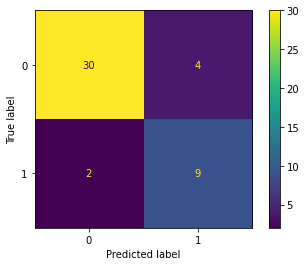

In [33]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lm_pipeline, X_test, y_test);

In [34]:
from sklearn.metrics import roc_curve, auc

In [35]:
y_decisionfun = lm_pipeline.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_decisionfun)
roc_auc = auc(fpr, tpr)

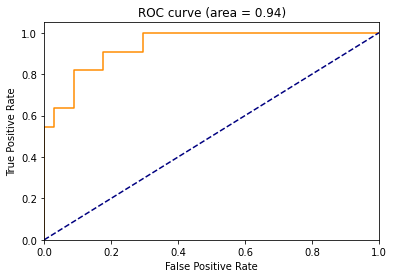

In [36]:
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (area = {roc_auc:0.2f})');

In [37]:
lm_coefs_df = pd.DataFrame({'coefs': lm_pipeline['logisticregression'].coef_[0]},
                           index=X_train.columns)

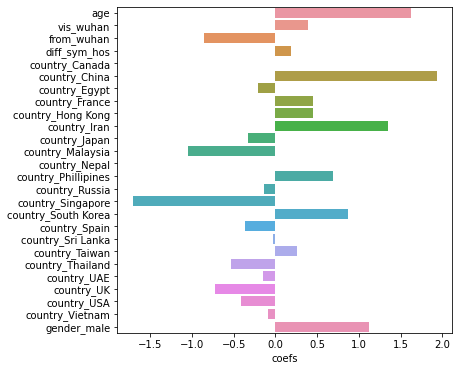

In [39]:
plt.figure(figsize=(6,6))
sns.barplot(x='coefs', y=lm_coefs_df.index, data=lm_coefs_df);

### Pitfall 5: not using cross-validation to assess generalizability

In [40]:
from sklearn.model_selection import StratifiedKFold

*** Evaluation metrics for fold 1 ***
Recall: 0.64, Precision Score: 0.88
F1 Score: 0.74, Accuracy: 0.86
*** Evaluation metrics for fold 2 ***
Recall: 0.73, Precision Score: 0.89
F1 Score: 0.80, Accuracy: 0.89
*** Evaluation metrics for fold 3 ***
Recall: 1.00, Precision Score: 0.91
F1 Score: 0.95, Accuracy: 0.97
*** Evaluation metrics for fold 4 ***
Recall: 0.80, Precision Score: 0.89
F1 Score: 0.84, Accuracy: 0.91
*** Evaluation metrics for fold 5 ***
Recall: 0.80, Precision Score: 1.00
F1 Score: 0.89, Accuracy: 0.94


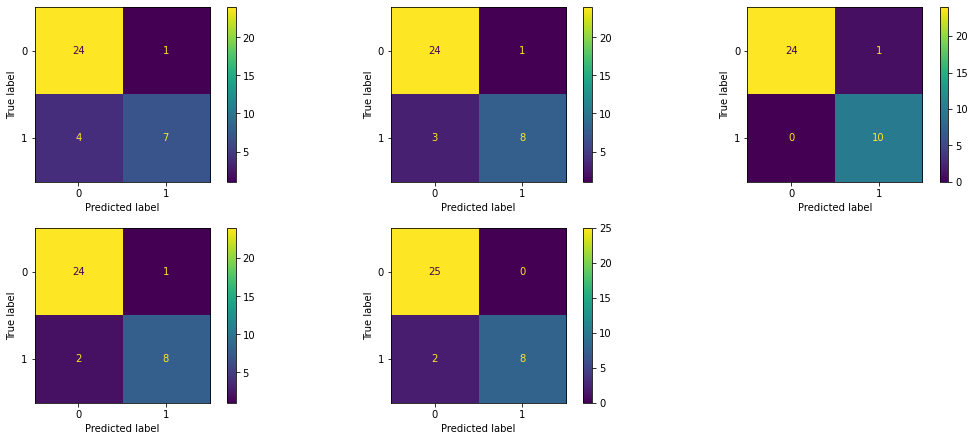

In [41]:
cv_coefs = []
n_folds = 5
n_cols_plot = 3
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
plt.figure(figsize=(15, 15))
for i_f, (ix_train, ix_test) in enumerate(skf.split(X_train, y_train)):
    # Define training and testing sets within folds
    X_fold_train = X_train.iloc[ix_train, :]
    y_fold_train = y_train.iloc[ix_train]
    X_fold_test = X_train.iloc[ix_test, :]
    y_fold_test = y_train.iloc[ix_test]
    # Fit the model for these folds training/testing sets
    lm_pipeline = make_pipeline(
        preprocessor,
        LogisticRegression()
    )
    lm_pipeline.fit(X_fold_train, y_fold_train)
    y_pred = lm_pipeline.predict(X_fold_test)
    # Scores
    recall_lr = rs(y_fold_test, y_pred)
    precision_lr = ps(y_fold_test, y_pred)
    f1_lr = fs(y_fold_test, y_pred)
    acc_lr = lm_pipeline.score(X_fold_test,y_fold_test)
    print(f'*** Evaluation metrics for fold {i_f+1} ***')
    print(f'Recall: {recall_lr:0.2f}, Precision Score: {precision_lr:0.2f}')
    print(f'F1 Score: {f1_lr:0.2f}, Accuracy: {acc_lr:0.2f}')
    ax = plt.subplot(n_folds, n_cols_plot, i_f+1)
    plot_confusion_matrix(lm_pipeline, X_fold_test, y_fold_test, ax=ax);
    cv_coefs.append(lm_pipeline['logisticregression'].coef_[0])
plt.tight_layout()
cv_coefs_df = pd.DataFrame(cv_coefs, columns=X_train.columns)

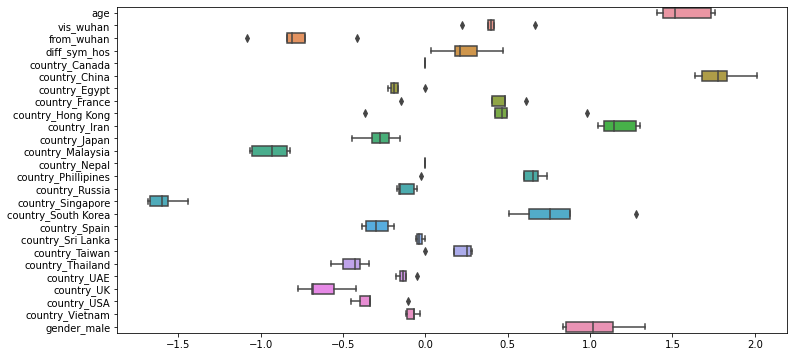

In [42]:
plt.figure(figsize=(12,6))
sns.boxplot(data=cv_coefs_df, orient='h');

### Pitfall 6: not using regularization when useful

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
lm_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, class_weight='balanced')
)
grid_search = GridSearchCV(lm_pipeline, 
                           param_grid={'logisticregression__l1_ratio':  np.linspace(0, 1, 11),
                                       'logisticregression__C': [0.1, 0.5, 1.0, 5.0, 10, 50, 100]})
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'diff_sym_hos'])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'logisticregression__C': [0.1, 0.5, 1.0, 5.0, 10, 50,
                                       

In [ ]:
GridSearchCV?

In [45]:
grid_search.best_params_

{'logisticregression__C': 5.0, 'logisticregression__l1_ratio': 0.4}

In [46]:
best_model = grid_search.best_estimator_

In [47]:
best_model['logisticregression'].coef_

array([[ 2.00795942,  0.20846561, -1.08129685, -0.63333271,  0.        ,
         3.89564334, -0.63202953,  1.33561427,  2.38055643,  3.00126114,
        -0.52475715, -2.08305387,  0.        ,  2.91693668, -0.21369215,
        -2.93221447,  1.69385172, -1.10152083,  0.        ,  0.85901281,
        -1.46941142,  0.        , -1.82431535, -1.39681699,  0.        ,
         1.90404395]])

*** Evaluation metrics for fold 1 ***
Recall: 0.82, Precision Score: 0.90
F1 Score: 0.86, Accuracy: 0.92
*** Evaluation metrics for fold 2 ***
Recall: 1.00, Precision Score: 0.79
F1 Score: 0.88, Accuracy: 0.92
*** Evaluation metrics for fold 3 ***
Recall: 1.00, Precision Score: 0.91
F1 Score: 0.95, Accuracy: 0.97
*** Evaluation metrics for fold 4 ***
Recall: 0.90, Precision Score: 0.90
F1 Score: 0.90, Accuracy: 0.94
*** Evaluation metrics for fold 5 ***
Recall: 0.90, Precision Score: 0.82
F1 Score: 0.86, Accuracy: 0.91


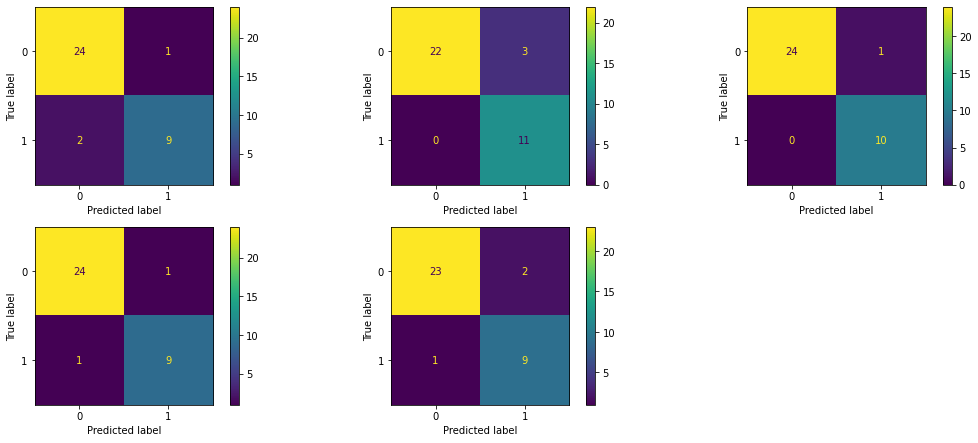

In [48]:
%%capture output --no-stdout --no-display
best_Cs = []
best_l1ratios = []
cv_coefs = []
n_folds = 5
n_cols_plot = 3
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
plt.figure(figsize=(15, 15))
for i_f, (ix_train, ix_test) in enumerate(skf.split(X_train, y_train)):
    # Define training and testing sets within folds
    X_fold_train = X_train.iloc[ix_train, :]
    y_fold_train = y_train.iloc[ix_train]
    X_fold_test = X_train.iloc[ix_test, :]
    y_fold_test = y_train.iloc[ix_test]
    # Fit the model for these folds training/testing sets
    lm_pipeline = make_pipeline(
        preprocessor,
        LogisticRegression(penalty='elasticnet', solver='saga', 
                           max_iter=10000, class_weight='balanced')
    )
    grid_search = GridSearchCV(lm_pipeline, 
                               param_grid={'logisticregression__l1_ratio': np.linspace(0, 1, 11),
                                           'logisticregression__C': [0.1, 0.5, 1.0, 5.0, 10, 50, 100]},
                              cv=5)
    grid_search.fit(X_train, y_train)
    best_Cs.append(grid_search.best_params_['logisticregression__C'])
    best_l1ratios.append(grid_search.best_params_['logisticregression__l1_ratio'])
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_fold_test)
    # Scores
    recall_lr = rs(y_fold_test, y_pred)
    precision_lr = ps(y_fold_test, y_pred)
    f1_lr = fs(y_fold_test, y_pred)
    acc_lr = best_model.score(X_fold_test,y_fold_test)
    print(f'*** Evaluation metrics for fold {i_f+1} ***')
    print(f'Recall: {recall_lr:0.2f}, Precision Score: {precision_lr:0.2f}')
    print(f'F1 Score: {f1_lr:0.2f}, Accuracy: {acc_lr:0.2f}')
    ax = plt.subplot(n_folds, n_cols_plot, i_f+1)
    plot_confusion_matrix(best_model, X_fold_test, y_fold_test, ax=ax);
    cv_coefs.append(best_model['logisticregression'].coef_[0])
plt.tight_layout()
cv_coefs_df = pd.DataFrame(cv_coefs, columns=X_train.columns)

In [49]:
best_Cs

[5.0, 5.0, 5.0, 5.0, 5.0]

In [50]:
best_l1ratios

[0.4, 0.4, 0.4, 0.4, 0.4]

### Pitfall 7: not keeping held out set for final evaluation 

In [51]:
lm_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, 
                       class_weight='balanced', l1_ratio=0.4, C=5.0)
)

*** Evaluation metrics for test dataset ***
Recall: 0.91, Precision Score: 0.62
F1 Score: 0.74, Accuracy: 0.84


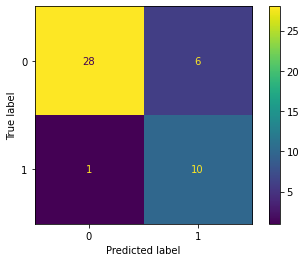

In [53]:
lm_pipeline.fit(X_train, y_train)
y_pred = np.array(lm_pipeline.predict(X_test))
# Scores
recall_lr = rs(y_test, y_pred)
precision_lr = ps(y_test, y_pred)
f1_lr = fs(y_test, y_pred)
acc_lr = lm_pipeline.score(X_test,y_test)
print('*** Evaluation metrics for test dataset ***')
print(f'Recall: {recall_lr:0.2f}, Precision Score: {precision_lr:0.2f}')
print(f'F1 Score: {f1_lr:0.2f}, Accuracy: {acc_lr:0.2f}')
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lm_pipeline, X_test, y_test);

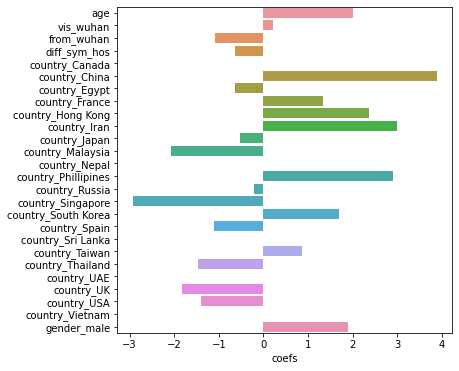

In [54]:
lm_coefs_df = pd.DataFrame({'coefs': lm_pipeline['logisticregression'].coef_[0]},
                           index=X_train.columns)
plt.figure(figsize=(6,6))
sns.barplot(x='coefs', y=lm_coefs_df.index, data=lm_coefs_df)

### Exercise

#### 1. Replace Logistic Regression below by an SVM classifier
* You can import it with `from sklearn import svm`
* To instantiate an SVM classifier, simply call `svm.LinearSVC()`
* Rename the pipeline `svm_pipeline`

In [ ]:
num_cols_to_scale = ['age', 'diff_sym_hos']
# Defining operator to scaling numerical column
preprocessor = make_column_transformer(
    (StandardScaler(), num_cols_to_scale),
     remainder='passthrough'
)
# Defining pipeline with both processing and model fitting
lm_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression()
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#### 2. Use the pipeline you defined above to make predictions on the test set
Rename the appropriate variable(s) below

In [ ]:
y_pred = np.array(lm_pipeline.predict(X_test))
# Scores
recall_lr = rs(y_test, y_pred)
precision_lr = ps(y_test, y_pred)
f1_lr = fs(y_test, y_pred)
acc_lr = lm_pipeline.score(X_test,y_test)
print('*** Evaluation metrics for test dataset ***')
print(f'Recall: {recall_lr:0.2f}, Precision Score: {precision_lr:0.2f}')
print(f'F1 Score: {f1_lr:0.2f}, Accuracy: {acc_lr:0.2f}')
plot_confusion_matrix(lm_pipeline, X_test, y_test);

#### 3. Plot the graph of the SVM classifier coefficients
Rename the appropriate variable(s) below

In [ ]:
lm_coefs_df = pd.DataFrame({'coefs': lm_pipeline['logisticregression'].coef_[0]},
                           index=X_train.columns)
# Plot
plt.figure(figsize=(6,6))
sns.barplot(x='coefs', y=lm_coefs_df.index, data=lm_coefs_df)

#### 4. Use cross-validation to assess the generalizability of your model
Rename the appropriate variable(s) below

In [ ]:
cv_coefs = []
n_folds = 5
n_cols_plot = 3
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
plt.figure(figsize=(15, 15))
for i_f, (ix_train, ix_test) in enumerate(skf.split(X_train, y_train)):
    # Define training and testing sets within folds
    X_fold_train = X_train.iloc[ix_train, :]
    y_fold_train = y_train.iloc[ix_train]
    X_fold_test = X_train.iloc[ix_test, :]
    y_fold_test = y_train.iloc[ix_test]
    # Fit the model for these folds training/testing sets
    lm_pipeline = make_pipeline(
        preprocessor,
        LogisticRegression()
    )
    lm_pipeline.fit(X_fold_train, y_fold_train)
    y_pred = lm_pipeline.predict(X_fold_test)
    # Scores
    recall_lr = rs(y_fold_test, y_pred)
    precision_lr = ps(y_fold_test, y_pred)
    f1_lr = fs(y_fold_test, y_pred)
    acc_lr = lm_pipeline.score(X_fold_test,y_fold_test)
    print(f'*** Evaluation metrics for fold {i_f+1} ***')
    print(f'Recall: {recall_lr:0.2f}, Precision Score: {precision_lr:0.2f}')
    print(f'F1 Score: {f1_lr:0.2f}, Accuracy: {acc_lr:0.2f}')
    ax = plt.subplot(n_folds, n_cols_plot, i_f+1)
    plot_confusion_matrix(lm_pipeline, X_fold_test, y_fold_test, ax=ax);
    cv_coefs.append(lm_pipeline['logisticregression'].coef_[0])
plt.tight_layout()
cv_coefs_df = pd.DataFrame(cv_coefs, columns=X_train.columns)

#### 5. Use GridSearch CV to find the best hyper-parameter C of your SVM classifier
Rename the appropriate variable(s) below

In [ ]:
best_Cs = []
best_l1ratios = []
cv_coefs = []
n_folds = 5
n_cols_plot = 3
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
plt.figure(figsize=(15, 15))
for i_f, (ix_train, ix_test) in enumerate(skf.split(X_train, y_train)):
    # Define training and testing sets within folds
    X_fold_train = X_train.iloc[ix_train, :]
    y_fold_train = y_train.iloc[ix_train]
    X_fold_test = X_train.iloc[ix_test, :]
    y_fold_test = y_train.iloc[ix_test]
    # Fit the model for these folds training/testing sets
    lm_pipeline = make_pipeline(
        preprocessor,
        LogisticRegression(penalty='elasticnet', solver='saga', 
                           max_iter=10000, class_weight='balanced')
    )
    grid_search = GridSearchCV(lm_pipeline, 
                               param_grid={'logisticregression__l1_ratio': np.linspace(0, 1, 11),
                                           'logisticregression__C': [0.1, 0.5, 1.0, 5.0, 10, 50, 100]},
                              cv=5)
    grid_search.fit(X_train, y_train)
    best_Cs.append(grid_search.best_params_['logisticregression__C'])
    best_l1ratios.append(grid_search.best_params_['logisticregression__l1_ratio'])
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_fold_test)
    # Scores
    recall_lr = rs(y_fold_test, y_pred)
    precision_lr = ps(y_fold_test, y_pred)
    f1_lr = fs(y_fold_test, y_pred)
    acc_lr = best_model.score(X_fold_test,y_fold_test)
    print(f'*** Evaluation metrics for fold {i_f+1} ***')
    print(f'Recall: {recall_lr:0.2f}, Precision Score: {precision_lr:0.2f}')
    print(f'F1 Score: {f1_lr:0.2f}, Accuracy: {acc_lr:0.2f}')
    ax = plt.subplot(n_folds, n_cols_plot, i_f+1)
    plot_confusion_matrix(best_model, X_fold_test, y_fold_test, ax=ax);
    cv_coefs.append(best_model['logisticregression'].coef_[0])
plt.tight_layout()
cv_coefs_df = pd.DataFrame(cv_coefs, columns=X_train.columns)

## Dimensionality reduction with PCA

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()

In [8]:
digits.data.shape

(1797, 64)

In [32]:
digits.target.shape

(1797,)

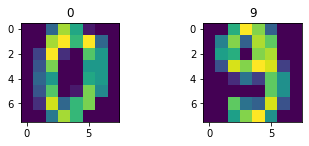

In [31]:
plt.figure(figsize=(6,4))
plt.subplot(2,2,1)
plt.imshow(digits.data[0,:].reshape(8,8));
plt.title(digits.target[0]);
plt.subplot(2,2,2)
plt.imshow(digits.data[455,:].reshape(8,8));
plt.title(digits.target[455]);

In [26]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=2)  # project from 64 to 2 dimensions
projected_digits = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected_digits.shape)

(1797, 64)
(1797, 2)


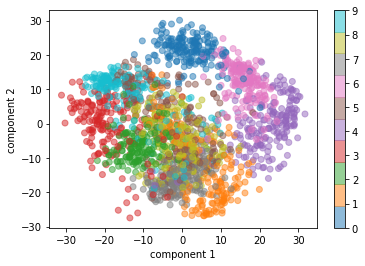

In [43]:
plt.scatter(projected_digits[:, 0], projected_digits[:, 1],
            c=digits.target, alpha=0.5, cmap="tab10")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

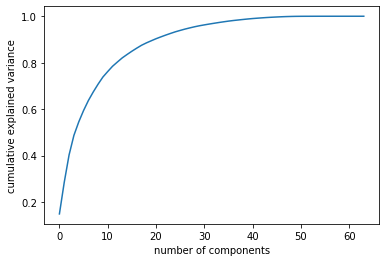

In [44]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Clustering (unsupervised learning)

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [49]:
X = scale(digits.data)
y = digits.target

In [51]:
n_digits = len(np.unique(y))

In [52]:
kmeans = KMeans(n_clusters=n_digits)
kmeans.fit(X)

KMeans(n_clusters=10)

In [57]:
X_pca = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=n_digits)
kmeans.fit(X_pca)

KMeans(n_clusters=10)

In [79]:
plt.scatter?

In [96]:
Z.shape

(927, 949)

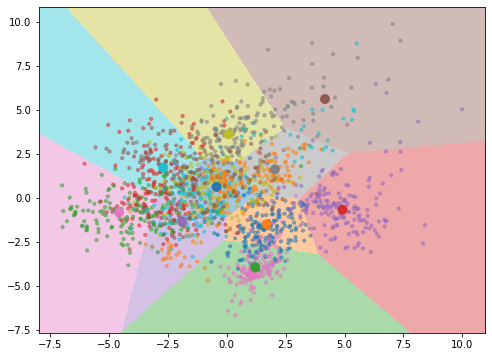

In [102]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='tab10', aspect='auto', origin='lower', alpha=0.4)

#plt.plot(X_pca[:, 0], X_pca[:, 1], 'w.', markersize=2)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits.target, cmap="tab10", s=10, alpha=0.5)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=50, alpha=0.9, 
            linewidths=3, zorder=10, c=np.unique(y), cmap="tab10")

In [106]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.37539732315682683
For n_clusters = 3 The average silhouette_score is : 0.3912163321880937
For n_clusters = 4 The average silhouette_score is : 0.38805013462719873
For n_clusters = 5 The average silhouette_score is : 0.37832386992080586
For n_clusters = 6 The average silhouette_score is : 0.3904337568998268
For n_clusters = 7 The average silhouette_score is : 0.3879306552155842
For n_clusters = 8 The average silhouette_score is : 0.39224215373116517
For n_clusters = 9 The average silhouette_score is : 0.37463814136950274
For n_clusters = 10 The average silhouette_score is : 0.375585172174949
For n_clusters = 11 The average silhouette_score is : 0.37139729595567195
For n_clusters = 12 The average silhouette_score is : 0.37670398745009076
For n_clusters = 13 The average silhouette_score is : 0.37698187659596993
For n_clusters = 14 The average silhouette_score is : 0.363799868409745


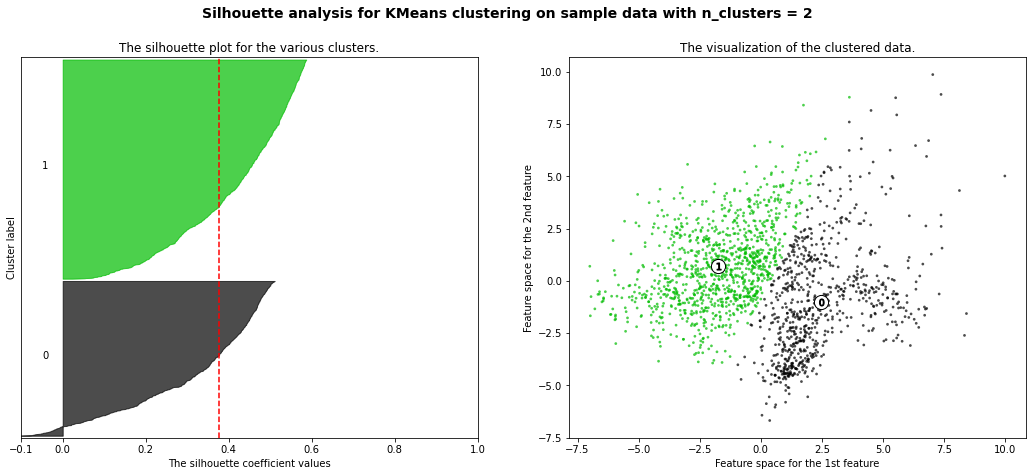

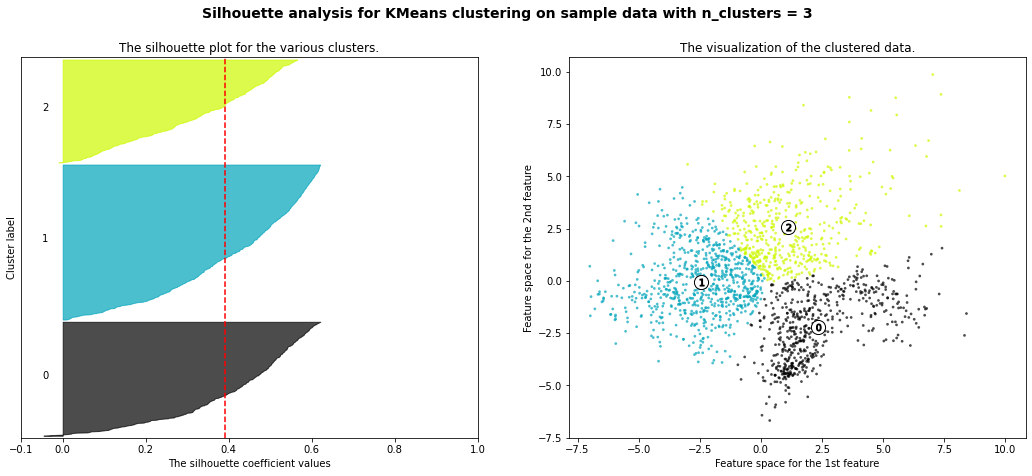

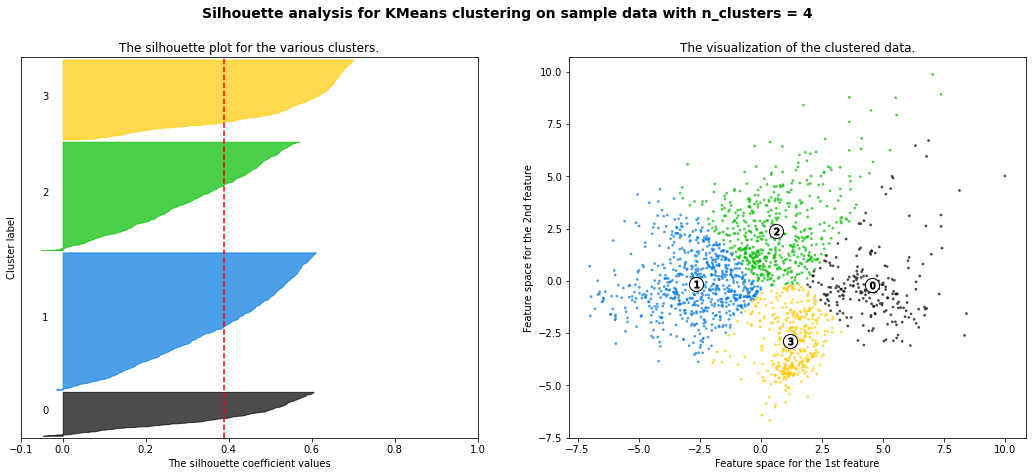

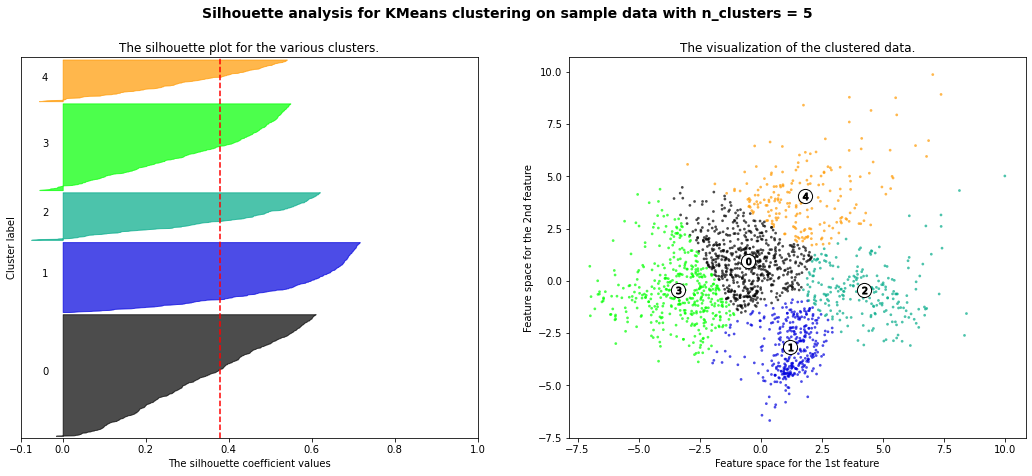

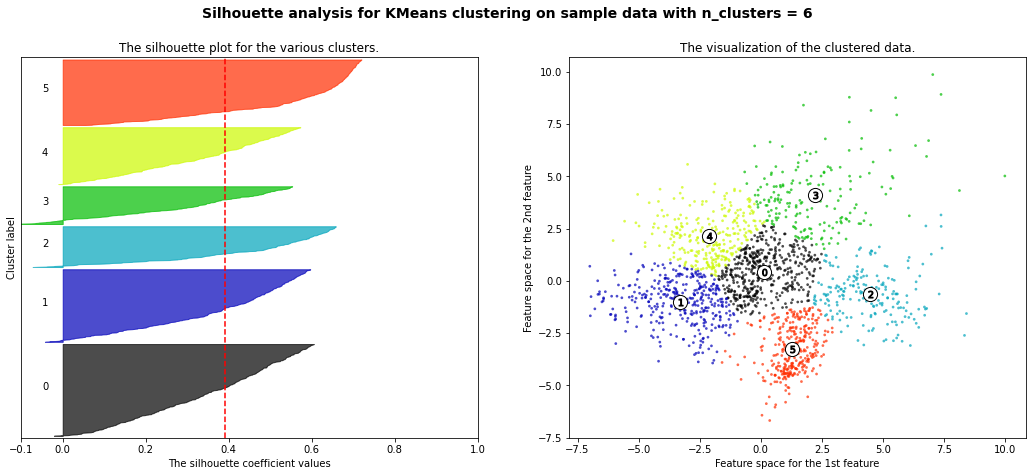

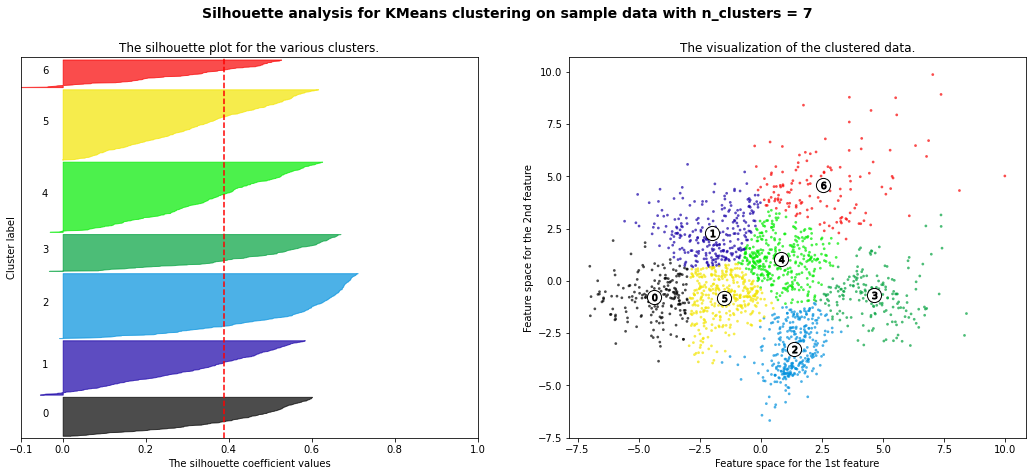

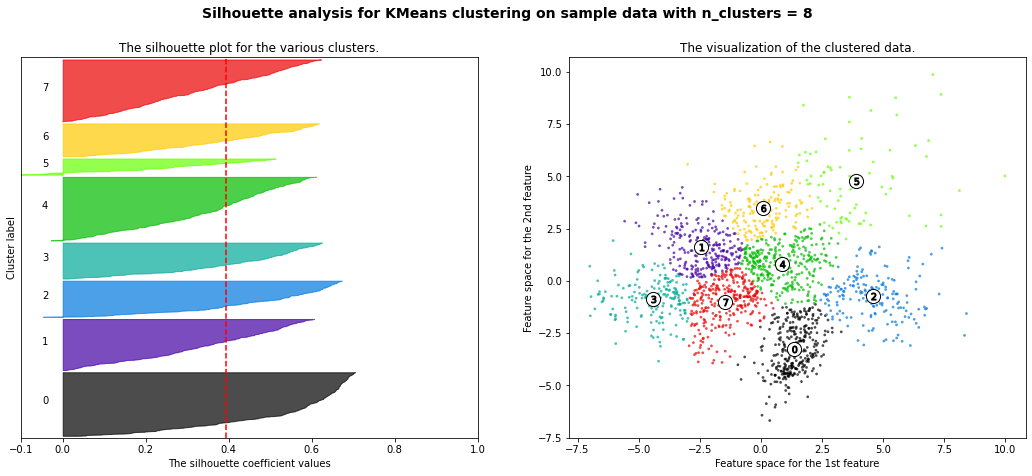

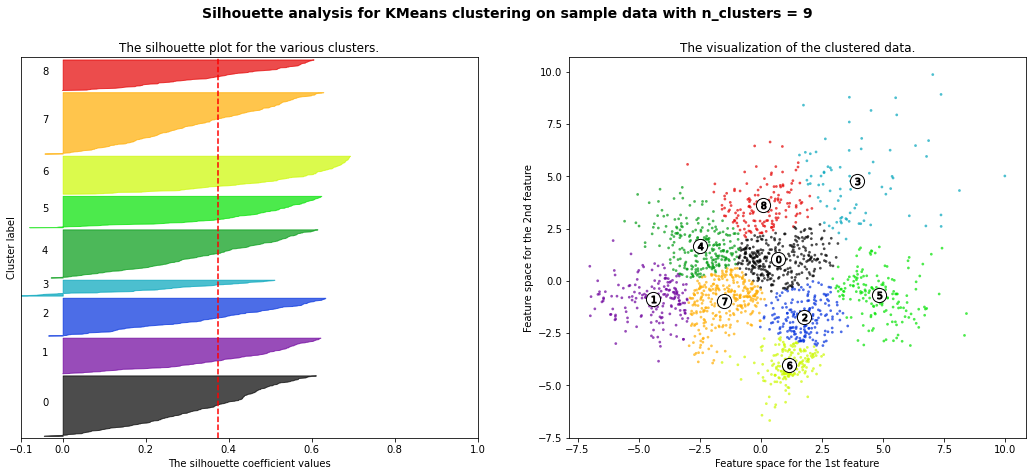

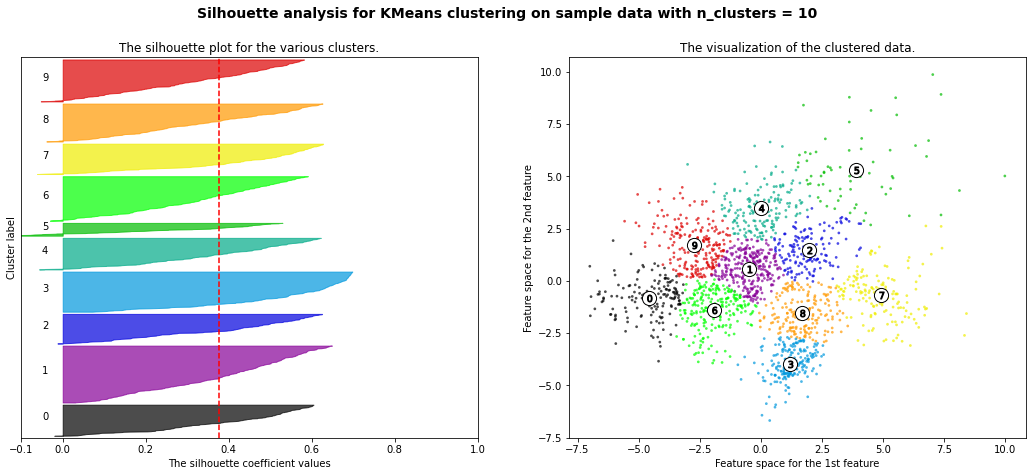

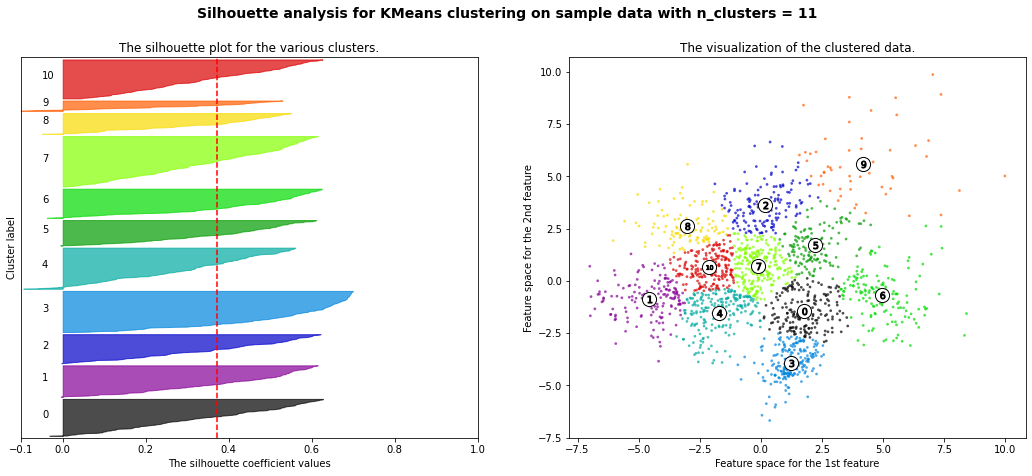

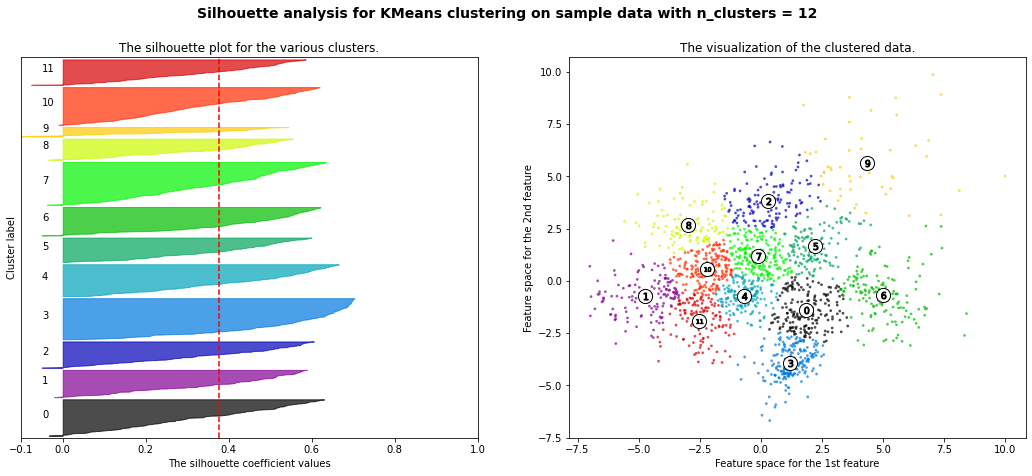

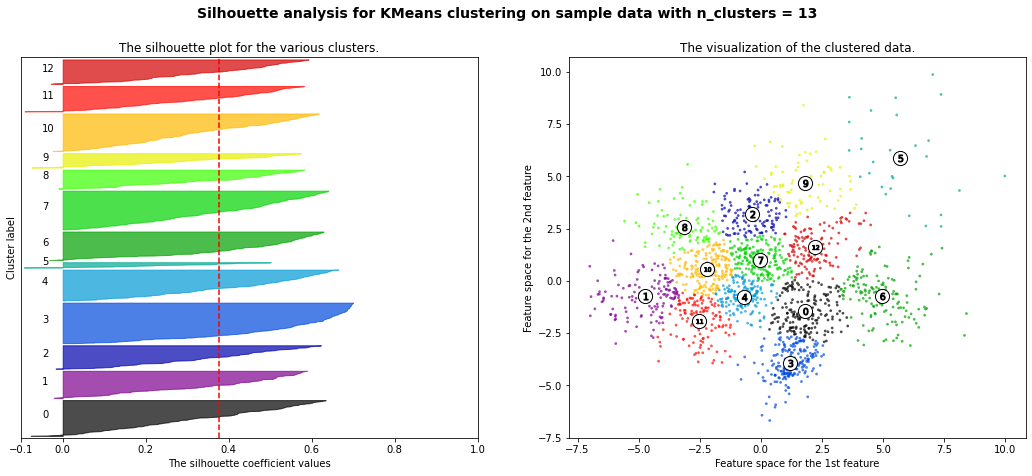

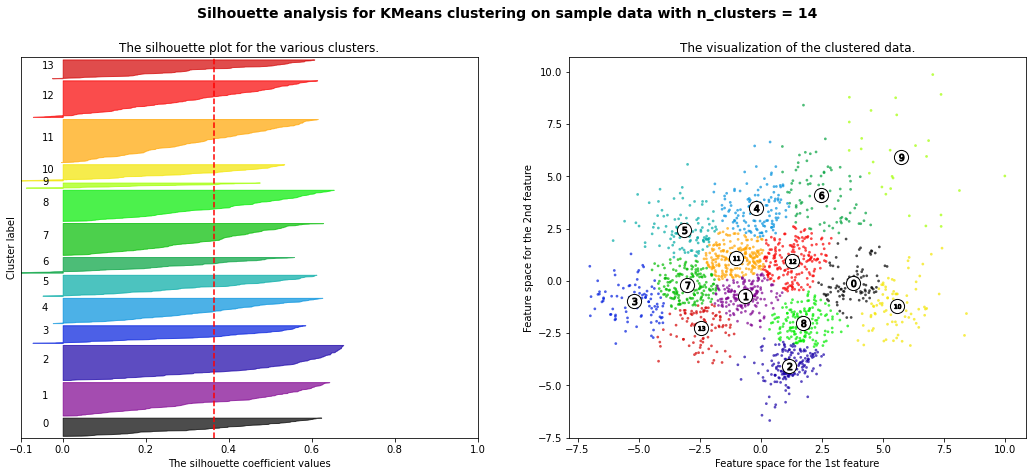

In [108]:
range_n_clusters = np.arange(2, 15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')